In [2]:
# Importing required packages
import numpy as np
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt


In [148]:
hs = pd.read_csv('../Power_Tower_Model/Hardening_Study.csv')
# Setting the excel input file

# ----------------------------- Reading network input data for the current grid --------------------------------------
# Setting the excel input file
import_current_data = 'Data/current_grid_2.xls'

# Reading the nodes data frame from the input file
current_power_nodes = pd.read_excel(import_current_data, sheet_name=0, header=0, index_col=0)

# Reading links data frame from the input file
current_power_links = pd.read_excel(import_current_data, sheet_name=1, header=0, index_col=0)

# Setting the number of nodes using input data
current_power_num_nodes = current_power_nodes.shape[0]

# Setting the number of links using input data
current_power_num_links = current_power_links.shape[0]


In [149]:
current_power_links['ID'].unique()

array([41300, 40100, 40200, 37100, 'Generator', 39800, 37400, 37600,
       38300, 50500, 50400, 50100, 50200, 50900, 51000, 50800, 50700,
       50300, 51100, 37200, 39100, 36100, 38200, 37500, 39000, 37900,
       38900, 41400, 36300, 41000, 40300, 37300, 36900, 40900, 36600,
       36500, 36400, 37800, 38100, 36200, 36800, 'Municipality'],
      dtype=object)

In [150]:
np.append(np.append(failed_ind,list(range(6))), list(range(7,12)))

array([32, 80, 85, 89, 91, 45, 75, 87, 88, 62, 57, 86, 90, 49, 55, 56, 30,
       31, 33, 59, 60, 64, 69, 71, 36, 37, 35, 74, 77, 72, 73, 79, 41, 76,
       34, 78, 81, 42, 82, 83, 38, 39, 40, 65, 67, 68, 70, 28, 48, 47, 66,
       46, 43, 44, 84, 15, 16, 17, 24, 12, 14, 22, 23, 21, 18, 19, 20,  0,
        1,  2,  3,  4,  5,  7,  8,  9, 10, 11])

{'h0': ['v', 'v']}

# All code in one block

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 50083 rows, 19670 columns and 118711 nonzeros
Model fingerprint: 0x8256d0d3
Variable types: 19320 continuous, 350 integer (350 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 2570.0000000
Presolve removed 50083 rows and 19670 columns
Presolve time: 0.03s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 1 (of 16 available processors)

Solution count 2: 2437.35 2570 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.437353760334e+03, best bound 2.437353760334e+03, gap 0.0000%
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 16 physical cores, 16 logical processors, using up to 16 thr

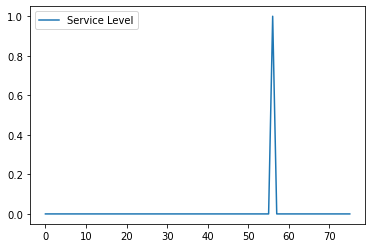

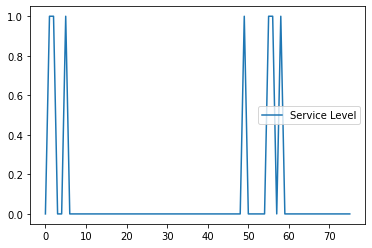

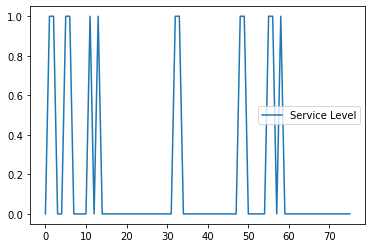

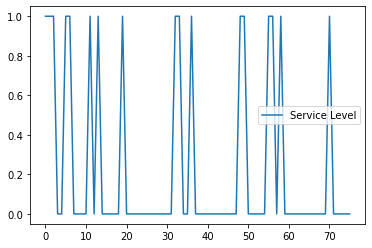

In [162]:
thre_list = [0.01]
c_supply = {'h0': [], 'h1': [], 'h2': [], 'h3': []}
    
for thre in thre_list:
    hs[f'h0'] = [ 1 if x > thre else 0 for x in hs['Current Infrastructure'] ]
    for i in range(1,4):
        hs[f'h{i}'] = [ 1 if x >= thre else 0 for x in hs[f'Hardening # {i}'] ]
    for h_num in range(4): 
        
#         hs[hs.columns[0:4]].plot()
#         plt.figure()
#         hs[hs.columns[-4:]].plot()
    
        
        # ---------------------------------------------------------------------------------------------------------------------
        
        links = hs.join(current_power_links.reset_index().set_index('ID'), on='ID')
        
        failed_ind = links.loc[links[f'h{h_num}'] == 1]['Link'].values
#         failed_ind = np.append(np.append(failed_ind,list(range(6))), list(range(7,12)))
        failed_ind.shape[0]
        
        # ---------------------------------Setting code input parameters (for both current and future grid) --------------
        # Setting the list of link indices which fail. Refere to links tab of input data excel files for indices
        power_failed_links = failed_ind.copy()
        
        # Setting the list of failure times (one for each failed link)
        power_fail_times = [0] * failed_ind.shape[0]
        
        # Setting the number of available repair teams
        power_num_servers = 1
        
        # Setting the lenght of planning horizon
        num_time_periods = 1
        
        # --------------------------------------------------------------------------------------------------------------------
        
        # Creating empty dictionaries to store the input parameters to the network flow model (current grid)
        current_power_demand = {}
        current_power_generation_capacity = {}
        current_power_storage_capacity = {}
        
        # Using input data to fill in demand and generation capacity dictionaries (current grid)
        for i in range(current_power_num_nodes):
            current_power_demand[i] = current_power_nodes["Demand"].iloc[i]
            current_power_generation_capacity[i] = current_power_nodes["Generation_Capacity"].iloc[i]
        
        # Filling in the repair duration list (current grid)
        current_power_repair_durations = []
        for i in range(current_power_num_links):
            current_power_repair_durations.append(current_power_links["Repair_Duration"].iloc[i])
        
        # Forming the set of repair teams (for both current and future grids)
        power_servers = range(power_num_servers)
        
        # Forming the set of time periods (for both current and future grids)
        time_periods = range(num_time_periods)
        
        # Creating the model object for network flow model (current grid)
        current_power_res_model = Model()
        
        # -----------  Defining the decision variables for optimal recovery of the current grid -------------------------
        
        # y_itj is a binary variable and is equal to one if j-th repair team starts to fix i-th link at time period t
        current_power_y = current_power_res_model.addVars(((i, t, j) for i in range(current_power_num_links)
                                                           for t in time_periods for j in power_servers), vtype=GRB.BINARY)
        
        # s_it is a binary deicsion variable and is equal to one if i-th link is functional at time period t
        current_power_s_links = current_power_res_model.addVars(((i, t) for i in range(current_power_num_links)
                                                                 for t in time_periods), vtype=GRB.BINARY)
        
        # ps_it is a continuous decision variable and is equal to the power supplied at i-th node at time period t
        current_power_supplied = current_power_res_model.addVars((i, t) for i in range(current_power_num_nodes)
                                                                 for t in time_periods)
        
        # pg_it is a continuous decision variable and is equal to the power generated at i-th node at time period t
        current_power_generated = current_power_res_model.addVars((i, t) for i in range(current_power_num_nodes)
                                                                  for t in time_periods)
        # f_ijt is a continuous decision variable and is equal to the power transmitted from i-th to j-th node at time period t
        current_power_transmitted = current_power_res_model.addVars((i, j, t) for i in range(current_power_num_nodes)
                                                            for j in range(current_power_num_nodes) for t in time_periods)
        
        # ---------------------------------------------------------------------------------------------------------------------
        
        # --------------- Using input data to form power transmission capacity matrix for current grid  ---------------------
        
        # Creating the matrix with all it its elements equal to zero
        current_power_transmission_capacity = np.zeros((current_power_num_nodes, current_power_num_nodes))
        
        # Reading source and target nodes of the different links using input data
        current_power_link_sources = current_power_links["From_Node"].values
        current_power_link_targets = current_power_links["To_Node"].values
        
        # Reading links transmission capacities from the input data
        current_power_link_capacities = current_power_links["Transmission_Capacity"].values
        
        # Reading links type from the input data, type 1 links are one-way links while type 2 links are two-way ones
        current_power_link_types = current_power_links["Type"].values
        
        # Using the above arrays to fill in the non-zero values in the tranmission capacity matrix created above
        for i in range(current_power_num_links):
            current_power_transmission_capacity[current_power_link_sources[i], current_power_link_targets[i]] = \
                current_power_link_capacities[i]
            if current_power_link_types[i] == 2:
                current_power_transmission_capacity[current_power_link_targets[i], current_power_link_sources[i]] = \
                    current_power_link_capacities[i]
        
        # -----------------------------------------------------------------------------------------------------------------
        
        # Creating the empty dictionary for network links. This dictionaty, takes (i,j) pairs of nodes as input and returns the
        # index of the link between the nodes i and j of the network (current grid)
        current_power_links_dic = {}
        
        # Filling in the key-value pairs in the dictionary created above (current grid)
        for i in range(current_power_num_links):
            current_power_links_dic[(current_power_link_sources[i], current_power_link_targets[i])] = i
            if current_power_link_types[i] == 2:
                current_power_links_dic[(current_power_link_targets[i], current_power_link_sources[i],)] = i
        
        # Setting power generation capacity for the current power network
        current_power_generation_capacity = current_power_nodes["Generation_Capacity"].values
        
        # ------------------------------------- Adding constrains to the optimal recovery problem for the current grid --------
        # These constraints state that after failure time each link of the power network will not be functional before
        # it is fixed
        current_power_res_model.addConstrs(current_power_s_links[power_failed_links[i], t] <=
                                           quicksum(current_power_y[power_failed_links[i], u, j] for u in
                                                    range(int(power_fail_times[i]), t - int(
                                                        current_power_repair_durations[power_failed_links[i]] + 1))
                                                    for j in power_servers) for i in range(len(power_failed_links))
                                           for t in range(power_fail_times[i], num_time_periods))
        
        # These constraints set the functionality indicator to one for all links of the power network which do not fail
        current_power_res_model.addConstrs(current_power_s_links[i, t] == 1 for i in range(current_power_num_links)
                                           for t in time_periods if i not in power_failed_links)
        
        # These constraints set the functionality indicator to one for all failed links of the power network
        # before their failure
        current_power_res_model.addConstrs(current_power_s_links[power_failed_links[i], t] == 1
                                           for i in range(len(power_failed_links)) for t in range(power_fail_times[i]))
        
        # These constraints mean that once a repair team starts fixing a power network link, it will not be available until
        # it finishes the ongoing restoration task
        current_power_res_model.addConstrs(current_power_y[i, j, k] <= 1 - current_power_y[p, q, k] for i in
                                           range(current_power_num_links) for j in time_periods for k in power_servers
                                           for p in range(current_power_num_links) if p != i
                                           for q in range(j, min(j+int(current_power_repair_durations[i]), num_time_periods)))
        
        # Power balance equation for different nodes of the network
        current_power_res_model.addConstrs(quicksum(current_power_transmitted[k, i, t] for k in range(current_power_num_nodes))
                                           + current_power_generated[i, t] == current_power_supplied[i, t] +
                                           quicksum(current_power_transmitted[i, k, t]
                                                    for k in range(current_power_num_nodes))
                                           for i in range(current_power_num_nodes) for t in range(num_time_periods))
        
        # Power generation capacity for the current power network
        current_power_res_model.addConstrs(current_power_generated[i, t] <= current_power_generation_capacity[i]
                                           for i in range(current_power_num_nodes) for t in time_periods)
        
        # Power transmission capacity for links considering only links availability
        for i in range(current_power_num_nodes):
            for j in range(current_power_num_nodes):
                if current_power_transmission_capacity[i, j] > 0:
                    current_power_res_model.addConstrs(current_power_transmitted[i, j, t] <=
                                                       current_power_transmission_capacity[i, j] *
                                                       current_power_s_links[current_power_links_dic[(i, j)], t]
                                                       for t in time_periods)
                else:
                    current_power_res_model.addConstrs(current_power_transmitted[i, j, t] == 0 for t in time_periods)
        
        # Supply limit at each node
        current_power_res_model.addConstrs(current_power_supplied[i, t] <= (current_power_demand[i])
                                           for i in range(current_power_num_nodes) for t in range(num_time_periods))
        # ---------------------------------------------------------------------------------------------------------------------
        
        # Forming the objective Function for the current power network
        current_power_res_model.setObjective(quicksum((current_power_demand[i] - current_power_supplied[i, t])
                                                      for i in range(current_power_num_nodes) for t in time_periods),
                                             GRB.MINIMIZE)
        
        # Solving the power restoration model for the current power network
        current_power_res_model.update
        current_power_res_model.optimize()
        
        # Extracting the optimal solution for the current power network
        current_power_supplied = np.reshape(current_power_res_model.getAttr('x', current_power_supplied).values(),
                                    (current_power_num_nodes, num_time_periods))
        current_power_avail_mat = np.reshape(current_power_res_model.getAttr('x', current_power_s_links).values(),
                                     (current_power_num_links, num_time_periods))
        current_power_recovery_times = []
        for cnt, val in enumerate(power_failed_links):
            current_power_s_component = current_power_avail_mat[val, power_fail_times[cnt]:]
            current_power_recovery_times.append(next((i for i, x in enumerate(current_power_s_component) if x), None))
        
        current_power_recovery_times
        
        # ----------------------------- Reading network data for the future grid ---------------------------------------------
        # Setting the input data file
        import_new_data = 'Data/future_grid.xls'
        
        # Forming nodes and links data frames for the future grid using input data file
        future_power_nodes = pd.read_excel(import_new_data, sheet_name=0, header=0, index_col=0)
        future_power_links = pd.read_excel(import_new_data, sheet_name=1, header=0, index_col=0)
        
        # Setting the number of nodes and links
        future_power_num_nodes = future_power_nodes.shape[0]
        future_power_num_links = future_power_links.shape[0]
        # --------------------------------------------------------------------------------------------------------------------
        
        # -------------------------------- Creating empty dictionaries to store the input parameters of the network flow model
        # for the future grid
        future_power_demand = {}
        future_power_generation_capacity = {}
        future_power_storage_capacity = {}
        
        # Using input data to fill in demand, generation capacity and storage capacities
        for i in range(future_power_num_nodes):
            future_power_demand[i] = future_power_nodes["Demand"].iloc[i]
            future_power_generation_capacity[i] = future_power_nodes["Generation_Capacity"].iloc[i]
            future_power_storage_capacity[i] = future_power_nodes['Storage_Capacity'].iloc[i]
        
        # Using input data to fill in the repair duration list
        future_power_repair_durations = []
        for i in range(future_power_num_links):
            future_power_repair_durations.append(future_power_links["Repair_Duration"].iloc[i])
        
        # Creating network flow model object for the future grid
        future_power_res_model = Model()
        
        # ---------------------  Defining the decision variables for the optimal recovery of the future grid -----------------
        # y_ijt is a binary decision variable equal to one if j-th team is assigned to i-th link at time period t
        future_power_y = future_power_res_model.addVars(((i, t, j) for i in range(future_power_num_links)
                                                           for t in time_periods for j in power_servers), vtype=GRB.BINARY)
        
        # s_it is a binary decision variable equal to one if i-th link is function at time period t
        future_power_s_links = future_power_res_model.addVars(((i, t) for i in range(future_power_num_links)
                                                                 for t in time_periods), vtype=GRB.BINARY)
        
        # ps_it is a continuous decision variable denoting the power supplied at i-th node of the network at time period t
        future_power_supplied = future_power_res_model.addVars((i, t) for i in range(future_power_num_nodes)
                                                                 for t in time_periods)
        
        # pg_it is a continuous decision variable noting the power generated at i-th node of the network at time period t
        future_power_generated = future_power_res_model.addVars((i, t) for i in range(future_power_num_nodes)
                                                                  for t in time_periods)
        
        # pt_ijt is a continuous decison variable noting the power transmitted over the link between i-th and j-th nodes of
        # the network
        future_power_transmitted = future_power_res_model.addVars((i, j, t) for i in range(future_power_num_nodes)
                                                            for j in range(future_power_num_nodes) for t in time_periods)
        
        # sp_it is a continuous decision variable denoting the power stored at i-th node at time period t
        future_power_stored = future_power_res_model.addVars((i, t) for i in range(future_power_num_nodes)for t in time_periods)
        
        # -------------------------------------------------------------------------------------------------------------------
        
        # --------------- Using input data to form power transmission capacity matrix for the future grid ---------------------
        
        # Creating the transmission capacity matrix and setting all its elements to zero
        future_power_transmission_capacity = np.zeros((future_power_num_nodes, future_power_num_nodes))
        
        # Reading the source and target nodes of different links of the network from input data
        future_power_link_sources = future_power_links["From_Node"].values
        future_power_link_targets = future_power_links["To_Node"].values
        
        # Reading transmission capacities using input data
        future_power_link_capacities = future_power_links["Transmission_Capacity"].values
        
        # Reading link type using input data. Link type 1 are one-way while link type 2 are two-way links
        future_power_link_types = future_power_links["Type"].values
        
        # Filling in the non-zero values of transmission capacity matrix using the above arrays
        for i in range(future_power_num_links):
            future_power_transmission_capacity[future_power_link_sources[i], future_power_link_targets[i]] = \
                future_power_link_capacities[i]
            if future_power_link_types[i] == 2:
                future_power_transmission_capacity[future_power_link_targets[i], future_power_link_sources[i]] = \
                    future_power_link_capacities[i]
        
        # ---------------------------------------------------------------------------------------------------------------------
        
        # Creating the empty links dictionary.
        future_power_links_dic = {}
        
        # Filling in the key-value pairs in the links dictionary defined above. This dictionary takes node pairs (i, j) as
        # input and returns the index of the link between the nodes
        for i in range(future_power_num_links):
            future_power_links_dic[(future_power_link_sources[i], future_power_link_targets[i])] = i
            if future_power_link_types[i] == 2:
                future_power_links_dic[(future_power_link_targets[i], future_power_link_sources[i], )] = i
        
        # Setting power generation capacity for the future grid
        future_power_generation_capacity = future_power_nodes["Generation_Capacity"].values
        
        # --------------------- Adding constraints to optimal recovery model for the future grid -----------------------------
        # These constraints state that after failure time each link of the power network will not be functional before
        # it is fixed
        future_power_res_model.addConstrs(future_power_s_links[power_failed_links[i], t] <=
                                       quicksum(future_power_y[power_failed_links[i], u, j] for u in range(
                                           int(power_fail_times[i]), t - int(
                                               future_power_repair_durations[power_failed_links[i]] + 1)) for j in power_servers)
                                       for i in range(len(power_failed_links)) for t in range(power_fail_times[i],
                                                                                              num_time_periods))
        
        # These constraints set the functionality indicator to one for all links of the power network which do not fail
        future_power_res_model.addConstrs(future_power_s_links[i, t] == 1 for i in range(future_power_num_links)
                                           for t in time_periods if i not in power_failed_links)
        
        # These constraints set the functionality indicator to one for all failed links of the power network before their
        # failure
        future_power_res_model.addConstrs(future_power_s_links[power_failed_links[i], t] == 1
                                           for i in range(len(power_failed_links)) for t in range(power_fail_times[i]))
        
        # These constraints mean that once a repair team starts fixing a power network link, it will not be available until
        # it finishes the ongoing restoration task
        future_power_res_model.addConstrs(future_power_y[i, j, k] <= 1 - future_power_y[p, q, k] for i in
                                           range(future_power_num_links) for j in time_periods for k in power_servers
                                           for p in range(future_power_num_links) if p != i
                                           for q in range(j, min(j+int(future_power_repair_durations[i]), num_time_periods)))
        
        # Power balance equation for the new power network at time periods 0, 1, 2, ..., nt-1
        future_power_res_model.addConstrs(future_power_stored[i, t] +
                                       quicksum(future_power_transmitted[k, i, t] for k in range(future_power_num_nodes)) +
                                       future_power_generated[i, t] == future_power_supplied[i, t] +
                                           quicksum(future_power_transmitted[i, k, t] + future_power_stored[i, t+1]
                                                    for k in range(future_power_num_nodes))
                                           for i in range(future_power_num_nodes) for t in range(num_time_periods-1))
        
        # Power balance equation for the new power network at the last time period
        future_power_res_model.addConstrs(future_power_stored[i, num_time_periods-1] +
                                       quicksum(future_power_transmitted[k, i, num_time_periods-1] for k in range(
                                           future_power_num_nodes)) + future_power_generated[i, num_time_periods-1] ==
                                          future_power_supplied[i, num_time_periods-1] +
                                          quicksum(future_power_transmitted[i, k, num_time_periods-1] for k in range(
                                              future_power_num_nodes)) for i in range(future_power_num_nodes))
        
        # Power generation capacity for the new power network
        future_power_res_model.addConstrs(future_power_generated[i, t] <= future_power_generation_capacity[i]
                                           for i in range(future_power_num_nodes) for t in time_periods)
        
        # Power storage capacity for the new power network
        future_power_res_model.addConstrs(future_power_stored[i, t] <= future_power_storage_capacity[i]
                                       for i in range(future_power_num_nodes) for t in time_periods)
        
        # Power transmission capacity for links considering only links availability for the new power network
        for i in range(future_power_num_nodes):
            for j in range(future_power_num_nodes):
                if future_power_transmission_capacity[i, j] > 0:
                    future_power_res_model.addConstrs(future_power_transmitted[i, j, t] <=
                                                       future_power_transmission_capacity[i, j] *
                                                       future_power_s_links[future_power_links_dic[(i, j)], t]
                                                       for t in time_periods)
                else:
                    future_power_res_model.addConstrs(future_power_transmitted[i, j, t] == 0 for t in time_periods)
        
        # Supply limit at each node of the new power network
        future_power_res_model.addConstrs(future_power_supplied[i, t] <= (future_power_demand[i])
                                           for i in range(future_power_num_nodes) for t in range(num_time_periods))
        
        # --------------------------------------------------------------------------------------------------------------------
        
        # Forming the objective Function for the future grid
        future_power_res_model.setObjective(quicksum((future_power_demand[i] - future_power_supplied[i, t])
                                                      for i in range(future_power_num_nodes) for t in time_periods), GRB.MINIMIZE)
        
        # Solving the power restoration model for the future grid
        future_power_res_model.update
        future_power_res_model.optimize()
        
        # Extracting the optimal solution for the future grid
        future_power_supplied = np.reshape(future_power_res_model.getAttr('x', future_power_supplied).values(),
                                    (future_power_num_nodes, num_time_periods))
        future_power_avail_mat = np.reshape(future_power_res_model.getAttr('x', future_power_s_links).values(),
                                     (future_power_num_links, num_time_periods))
        future_power_recovery_times = []
        for cnt, val in enumerate(power_failed_links):
            future_power_s_component = future_power_avail_mat[val, power_fail_times[cnt]:]
            future_power_recovery_times.append(next((i for i, x in enumerate(future_power_s_component) if x), None))
        
        # Creating supplied power data frame for the current grid
        muns = list(current_power_nodes['Node_Name'].values[62:])
        column_names = []
        for i in range(num_time_periods):
            column_names.append('Time_Period_' + str(i+1))
        current_supply_df = pd.DataFrame({column_names[k]: list(current_power_supplied[62:138, k])
        for k in range(num_time_periods)})
        current_supply_df.insert(0, 'Municipality', muns.copy())
        
        # Creating supplied power data frame for the future grid
        future_supply_df = pd.DataFrame({column_names[k]: list(future_power_supplied[62:138, k])
        for k in range(num_time_periods)})
        future_supply_df.insert(0, 'Municipality', muns.copy())
        
        # Creating network service level data frame for both current and future grid
        current_service_list = np.sum(current_power_supplied, axis=0)/np.sum(current_power_nodes["Demand"].values) * 100
        future_service_list = np.sum(future_power_supplied, axis=0)/np.sum(future_power_nodes["Demand"].values) * 100
        service_level_df = pd.DataFrame({'Time_Period': list(time_periods), 'Service_Current': current_service_list,
                                         'Service_Future': future_service_list })
        
        # Service Level by Municipality
        
        c_supply_df = current_supply_df.join(current_power_nodes.set_index('Node_Name')['Demand'], on='Municipality')
        c_supply_df['Service Level'] = c_supply_df['Time_Period_1']/c_supply_df['Demand']
        c_supply[f'h{h_num}'].append(c_supply_df)
#         print(c_supply_df)
        c_supply_df.plot(y = 'Service Level')

In [177]:
service_level_h = pd.DataFrame()
service_level_h['Municipality'] = c_supply[f'h{i}'][0].loc[c_supply[f'h{i}'][0]['Municipality'].isin(study_area), 'Municipality']
service_level_h['Demand'] = c_supply[f'h{i}'][0].loc[c_supply[f'h{i}'][0]['Municipality'].isin(study_area), 'Demand']

for i in range(4):
#     c_supply[f'h{i}'][0].loc[c_supply[f'h{i}'][0]['Municipality'].isin(study_area)].plot.barh(x = 'Municipality', y = 'Service Level')
    service_level_h[[f'h{i} Service Level', f'h{i} Supply']] = c_supply[f'h{i}'][0].loc[c_supply[f'h{i}'][0]['Municipality'].isin(study_area), ['Service Level', 'Time_Period_1']]

In [185]:
service_level_h

,Municipality,Demand,h0 Service Level,h0 Supply,h1 Service Level,h1 Supply,h2 Service Level,h2 Supply,h3 Service Level,h3 Supply
1,Aguada,18.208246,0.0,0.0,1.0,18.208246,1.0,18.208246,1.0,18.208246
2,Aguadilla,47.600972,0.0,0.0,1.0,47.600972,1.0,47.600972,1.0,47.600972
5,Añasco,29.849644,0.0,0.0,1.0,29.849644,1.0,29.849644,1.0,29.849644
33,Hormigueros,8.513173,0.0,0.0,0.0,0.000000,1.0,8.513173,1.0,8.513173
35,Isabela,21.289861,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
48,Mayagüez,76.731217,0.0,0.0,0.0,0.000000,1.0,76.731217,1.0,76.731217
49,Moca,18.958879,0.0,0.0,1.0,18.958879,1.0,18.958879,1.0,18.958879
58,Rincón,6.704276,0.0,0.0,1.0,6.704276,1.0,6.704276,1.0,6.704276


In [187]:
service_level_h.to_csv(f'Data/Hardening_Results.csv', index = False)

# Normal code

In [98]:
thre = 0.04
hs['h0'] = [ 1 if x >= thre else 0 for x in hs['Current Infrastructure'] ]
for i in range(1,4):
    hs[f'h{i}'] = [ 1 if x >= thre else 0 for x in hs[f'Hardening # {i}'] ]

<AxesSubplot:>

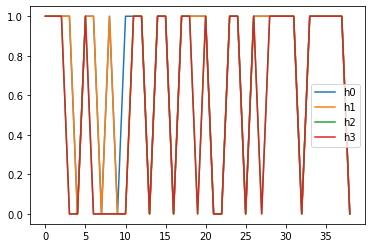

In [5]:
hs[hs.columns[-4:]].plot()

In [6]:
# ----------------------------- Reading network input data for the current grid --------------------------------------
# Setting the excel input file
import_current_data = 'Data/current_grid_2.xls'

# Reading the nodes data frame from the input file
current_power_nodes = pd.read_excel(import_current_data, sheet_name=0, header=0, index_col=0)

# Reading links data frame from the input file
current_power_links = pd.read_excel(import_current_data, sheet_name=1, header=0, index_col=0)

# Setting the number of nodes using input data
current_power_num_nodes = current_power_nodes.shape[0]

# Setting the number of links using input data
current_power_num_links = current_power_links.shape[0]

# ---------------------------------------------------------------------------------------------------------------------

In [7]:
links = hs.join(current_power_links.reset_index().set_index('ID'), on='ID')

In [8]:
failed_ind = links.loc[links['h0'] == 1]['Link'].values
failed_ind.shape[0]

65

In [9]:
# ---------------------------------Setting code input parameters (for both current and future grid) --------------
# Setting the list of link indices which fail. Refere to links tab of input data excel files for indices
power_failed_links = links.loc[links['h0'] == 1]['Link'].values

# Setting the list of failure times (one for each failed link)
power_fail_times = [0] * failed_ind.shape[0]

# Setting the number of available repair teams
power_num_servers = 1

# Setting the lenght of planning horizon
num_time_periods = 1

# --------------------------------------------------------------------------------------------------------------------

In [10]:
# Creating empty dictionaries to store the input parameters to the network flow model (current grid)
current_power_demand = {}
current_power_generation_capacity = {}
current_power_storage_capacity = {}

# Using input data to fill in demand and generation capacity dictionaries (current grid)
for i in range(current_power_num_nodes):
    current_power_demand[i] = current_power_nodes["Demand"].iloc[i]
    current_power_generation_capacity[i] = current_power_nodes["Generation_Capacity"].iloc[i]

# Filling in the repair duration list (current grid)
current_power_repair_durations = []
for i in range(current_power_num_links):
    current_power_repair_durations.append(current_power_links["Repair_Duration"].iloc[i])

# Forming the set of repair teams (for both current and future grids)
power_servers = range(power_num_servers)

# Forming the set of time periods (for both current and future grids)
time_periods = range(num_time_periods)

# Creating the model object for network flow model (current grid)
current_power_res_model = Model()

# -----------  Defining the decision variables for optimal recovery of the current grid -------------------------

# y_itj is a binary variable and is equal to one if j-th repair team starts to fix i-th link at time period t
current_power_y = current_power_res_model.addVars(((i, t, j) for i in range(current_power_num_links)
                                                   for t in time_periods for j in power_servers), vtype=GRB.BINARY)

# s_it is a binary deicsion variable and is equal to one if i-th link is functional at time period t
current_power_s_links = current_power_res_model.addVars(((i, t) for i in range(current_power_num_links)
                                                         for t in time_periods), vtype=GRB.BINARY)

# ps_it is a continuous decision variable and is equal to the power supplied at i-th node at time period t
current_power_supplied = current_power_res_model.addVars((i, t) for i in range(current_power_num_nodes)
                                                         for t in time_periods)

# pg_it is a continuous decision variable and is equal to the power generated at i-th node at time period t
current_power_generated = current_power_res_model.addVars((i, t) for i in range(current_power_num_nodes)
                                                          for t in time_periods)
# f_ijt is a continuous decision variable and is equal to the power transmitted from i-th to j-th node at time period t
current_power_transmitted = current_power_res_model.addVars((i, j, t) for i in range(current_power_num_nodes)
                                                    for j in range(current_power_num_nodes) for t in time_periods)

# ---------------------------------------------------------------------------------------------------------------------

# --------------- Using input data to form power transmission capacity matrix for current grid  ---------------------

# Creating the matrix with all it its elements equal to zero
current_power_transmission_capacity = np.zeros((current_power_num_nodes, current_power_num_nodes))

# Reading source and target nodes of the different links using input data
current_power_link_sources = current_power_links["From_Node"].values
current_power_link_targets = current_power_links["To_Node"].values

# Reading links transmission capacities from the input data
current_power_link_capacities = current_power_links["Transmission_Capacity"].values

# Reading links type from the input data, type 1 links are one-way links while type 2 links are two-way ones
current_power_link_types = current_power_links["Type"].values

# Using the above arrays to fill in the non-zero values in the tranmission capacity matrix created above
for i in range(current_power_num_links):
    current_power_transmission_capacity[current_power_link_sources[i], current_power_link_targets[i]] = \
        current_power_link_capacities[i]
    if current_power_link_types[i] == 2:
        current_power_transmission_capacity[current_power_link_targets[i], current_power_link_sources[i]] = \
            current_power_link_capacities[i]

# -----------------------------------------------------------------------------------------------------------------

# Creating the empty dictionary for network links. This dictionaty, takes (i,j) pairs of nodes as input and returns the
# index of the link between the nodes i and j of the network (current grid)
current_power_links_dic = {}

# Filling in the key-value pairs in the dictionary created above (current grid)
for i in range(current_power_num_links):
    current_power_links_dic[(current_power_link_sources[i], current_power_link_targets[i])] = i
    if current_power_link_types[i] == 2:
        current_power_links_dic[(current_power_link_targets[i], current_power_link_sources[i],)] = i

# Setting power generation capacity for the current power network
current_power_generation_capacity = current_power_nodes["Generation_Capacity"].values

# ------------------------------------- Adding constrains to the optimal recovery problem for the current grid --------
# These constraints state that after failure time each link of the power network will not be functional before
# it is fixed
current_power_res_model.addConstrs(current_power_s_links[power_failed_links[i], t] <=
                                   quicksum(current_power_y[power_failed_links[i], u, j] for u in
                                            range(int(power_fail_times[i]), t - int(
                                                current_power_repair_durations[power_failed_links[i]] + 1))
                                            for j in power_servers) for i in range(len(power_failed_links))
                                   for t in range(power_fail_times[i], num_time_periods))

# These constraints set the functionality indicator to one for all links of the power network which do not fail
current_power_res_model.addConstrs(current_power_s_links[i, t] == 1 for i in range(current_power_num_links)
                                   for t in time_periods if i not in power_failed_links)

# These constraints set the functionality indicator to one for all failed links of the power network
# before their failure
current_power_res_model.addConstrs(current_power_s_links[power_failed_links[i], t] == 1
                                   for i in range(len(power_failed_links)) for t in range(power_fail_times[i]))

# These constraints mean that once a repair team starts fixing a power network link, it will not be available until
# it finishes the ongoing restoration task
current_power_res_model.addConstrs(current_power_y[i, j, k] <= 1 - current_power_y[p, q, k] for i in
                                   range(current_power_num_links) for j in time_periods for k in power_servers
                                   for p in range(current_power_num_links) if p != i
                                   for q in range(j, min(j+int(current_power_repair_durations[i]), num_time_periods)))

# Power balance equation for different nodes of the network
current_power_res_model.addConstrs(quicksum(current_power_transmitted[k, i, t] for k in range(current_power_num_nodes))
                                   + current_power_generated[i, t] == current_power_supplied[i, t] +
                                   quicksum(current_power_transmitted[i, k, t]
                                            for k in range(current_power_num_nodes))
                                   for i in range(current_power_num_nodes) for t in range(num_time_periods))

# Power generation capacity for the current power network
current_power_res_model.addConstrs(current_power_generated[i, t] <= current_power_generation_capacity[i]
                                   for i in range(current_power_num_nodes) for t in time_periods)

# Power transmission capacity for links considering only links availability
for i in range(current_power_num_nodes):
    for j in range(current_power_num_nodes):
        if current_power_transmission_capacity[i, j] > 0:
            current_power_res_model.addConstrs(current_power_transmitted[i, j, t] <=
                                               current_power_transmission_capacity[i, j] *
                                               current_power_s_links[current_power_links_dic[(i, j)], t]
                                               for t in time_periods)
        else:
            current_power_res_model.addConstrs(current_power_transmitted[i, j, t] == 0 for t in time_periods)

# Supply limit at each node
current_power_res_model.addConstrs(current_power_supplied[i, t] <= (current_power_demand[i])
                                   for i in range(current_power_num_nodes) for t in range(num_time_periods))
# ---------------------------------------------------------------------------------------------------------------------

# Forming the objective Function for the current power network
current_power_res_model.setObjective(quicksum((current_power_demand[i] - current_power_supplied[i, t])
                                              for i in range(current_power_num_nodes) for t in time_periods),
                                     GRB.MINIMIZE)

# Solving the power restoration model for the current power network
current_power_res_model.update
current_power_res_model.optimize()

# Extracting the optimal solution for the current power network
current_power_supplied = np.reshape(current_power_res_model.getAttr('x', current_power_supplied).values(),
                            (current_power_num_nodes, num_time_periods))
current_power_avail_mat = np.reshape(current_power_res_model.getAttr('x', current_power_s_links).values(),
                             (current_power_num_links, num_time_periods))
current_power_recovery_times = []
for cnt, val in enumerate(power_failed_links):
    current_power_s_component = current_power_avail_mat[val, power_fail_times[cnt]:]
    current_power_recovery_times.append(next((i for i, x in enumerate(current_power_s_component) if x), None))

current_power_recovery_times

# ----------------------------- Reading network data for the future grid ---------------------------------------------
# Setting the input data file
import_new_data = 'Data/future_grid.xls'

# Forming nodes and links data frames for the future grid using input data file
future_power_nodes = pd.read_excel(import_new_data, sheet_name=0, header=0, index_col=0)
future_power_links = pd.read_excel(import_new_data, sheet_name=1, header=0, index_col=0)

# Setting the number of nodes and links
future_power_num_nodes = future_power_nodes.shape[0]
future_power_num_links = future_power_links.shape[0]
# --------------------------------------------------------------------------------------------------------------------

# -------------------------------- Creating empty dictionaries to store the input parameters of the network flow model
# for the future grid
future_power_demand = {}
future_power_generation_capacity = {}
future_power_storage_capacity = {}

# Using input data to fill in demand, generation capacity and storage capacities
for i in range(future_power_num_nodes):
    future_power_demand[i] = future_power_nodes["Demand"].iloc[i]
    future_power_generation_capacity[i] = future_power_nodes["Generation_Capacity"].iloc[i]
    future_power_storage_capacity[i] = future_power_nodes['Storage_Capacity'].iloc[i]

# Using input data to fill in the repair duration list
future_power_repair_durations = []
for i in range(future_power_num_links):
    future_power_repair_durations.append(future_power_links["Repair_Duration"].iloc[i])

# Creating network flow model object for the future grid
future_power_res_model = Model()

# ---------------------  Defining the decision variables for the optimal recovery of the future grid -----------------
# y_ijt is a binary decision variable equal to one if j-th team is assigned to i-th link at time period t
future_power_y = future_power_res_model.addVars(((i, t, j) for i in range(future_power_num_links)
                                                   for t in time_periods for j in power_servers), vtype=GRB.BINARY)

# s_it is a binary decision variable equal to one if i-th link is function at time period t
future_power_s_links = future_power_res_model.addVars(((i, t) for i in range(future_power_num_links)
                                                         for t in time_periods), vtype=GRB.BINARY)

# ps_it is a continuous decision variable denoting the power supplied at i-th node of the network at time period t
future_power_supplied = future_power_res_model.addVars((i, t) for i in range(future_power_num_nodes)
                                                         for t in time_periods)

# pg_it is a continuous decision variable noting the power generated at i-th node of the network at time period t
future_power_generated = future_power_res_model.addVars((i, t) for i in range(future_power_num_nodes)
                                                          for t in time_periods)

# pt_ijt is a continuous decison variable noting the power transmitted over the link between i-th and j-th nodes of
# the network
future_power_transmitted = future_power_res_model.addVars((i, j, t) for i in range(future_power_num_nodes)
                                                    for j in range(future_power_num_nodes) for t in time_periods)

# sp_it is a continuous decision variable denoting the power stored at i-th node at time period t
future_power_stored = future_power_res_model.addVars((i, t) for i in range(future_power_num_nodes)for t in time_periods)

# -------------------------------------------------------------------------------------------------------------------

# --------------- Using input data to form power transmission capacity matrix for the future grid ---------------------

# Creating the transmission capacity matrix and setting all its elements to zero
future_power_transmission_capacity = np.zeros((future_power_num_nodes, future_power_num_nodes))

# Reading the source and target nodes of different links of the network from input data
future_power_link_sources = future_power_links["From_Node"].values
future_power_link_targets = future_power_links["To_Node"].values

# Reading transmission capacities using input data
future_power_link_capacities = future_power_links["Transmission_Capacity"].values

# Reading link type using input data. Link type 1 are one-way while link type 2 are two-way links
future_power_link_types = future_power_links["Type"].values

# Filling in the non-zero values of transmission capacity matrix using the above arrays
for i in range(future_power_num_links):
    future_power_transmission_capacity[future_power_link_sources[i], future_power_link_targets[i]] = \
        future_power_link_capacities[i]
    if future_power_link_types[i] == 2:
        future_power_transmission_capacity[future_power_link_targets[i], future_power_link_sources[i]] = \
            future_power_link_capacities[i]

# ---------------------------------------------------------------------------------------------------------------------

# Creating the empty links dictionary.
future_power_links_dic = {}

# Filling in the key-value pairs in the links dictionary defined above. This dictionary takes node pairs (i, j) as
# input and returns the index of the link between the nodes
for i in range(future_power_num_links):
    future_power_links_dic[(future_power_link_sources[i], future_power_link_targets[i])] = i
    if future_power_link_types[i] == 2:
        future_power_links_dic[(future_power_link_targets[i], future_power_link_sources[i], )] = i

# Setting power generation capacity for the future grid
future_power_generation_capacity = future_power_nodes["Generation_Capacity"].values

# --------------------- Adding constraints to optimal recovery model for the future grid -----------------------------
# These constraints state that after failure time each link of the power network will not be functional before
# it is fixed
future_power_res_model.addConstrs(future_power_s_links[power_failed_links[i], t] <=
                               quicksum(future_power_y[power_failed_links[i], u, j] for u in range(
                                   int(power_fail_times[i]), t - int(
                                       future_power_repair_durations[power_failed_links[i]] + 1)) for j in power_servers)
                               for i in range(len(power_failed_links)) for t in range(power_fail_times[i],
                                                                                      num_time_periods))

# These constraints set the functionality indicator to one for all links of the power network which do not fail
future_power_res_model.addConstrs(future_power_s_links[i, t] == 1 for i in range(future_power_num_links)
                                   for t in time_periods if i not in power_failed_links)

# These constraints set the functionality indicator to one for all failed links of the power network before their
# failure
future_power_res_model.addConstrs(future_power_s_links[power_failed_links[i], t] == 1
                                   for i in range(len(power_failed_links)) for t in range(power_fail_times[i]))

# These constraints mean that once a repair team starts fixing a power network link, it will not be available until
# it finishes the ongoing restoration task
future_power_res_model.addConstrs(future_power_y[i, j, k] <= 1 - future_power_y[p, q, k] for i in
                                   range(future_power_num_links) for j in time_periods for k in power_servers
                                   for p in range(future_power_num_links) if p != i
                                   for q in range(j, min(j+int(future_power_repair_durations[i]), num_time_periods)))

# Power balance equation for the new power network at time periods 0, 1, 2, ..., nt-1
future_power_res_model.addConstrs(future_power_stored[i, t] +
                               quicksum(future_power_transmitted[k, i, t] for k in range(future_power_num_nodes)) +
                               future_power_generated[i, t] == future_power_supplied[i, t] +
                                   quicksum(future_power_transmitted[i, k, t] + future_power_stored[i, t+1]
                                            for k in range(future_power_num_nodes))
                                   for i in range(future_power_num_nodes) for t in range(num_time_periods-1))

# Power balance equation for the new power network at the last time period
future_power_res_model.addConstrs(future_power_stored[i, num_time_periods-1] +
                               quicksum(future_power_transmitted[k, i, num_time_periods-1] for k in range(
                                   future_power_num_nodes)) + future_power_generated[i, num_time_periods-1] ==
                                  future_power_supplied[i, num_time_periods-1] +
                                  quicksum(future_power_transmitted[i, k, num_time_periods-1] for k in range(
                                      future_power_num_nodes)) for i in range(future_power_num_nodes))

# Power generation capacity for the new power network
future_power_res_model.addConstrs(future_power_generated[i, t] <= future_power_generation_capacity[i]
                                   for i in range(future_power_num_nodes) for t in time_periods)

# Power storage capacity for the new power network
future_power_res_model.addConstrs(future_power_stored[i, t] <= future_power_storage_capacity[i]
                               for i in range(future_power_num_nodes) for t in time_periods)

# Power transmission capacity for links considering only links availability for the new power network
for i in range(future_power_num_nodes):
    for j in range(future_power_num_nodes):
        if future_power_transmission_capacity[i, j] > 0:
            future_power_res_model.addConstrs(future_power_transmitted[i, j, t] <=
                                               future_power_transmission_capacity[i, j] *
                                               future_power_s_links[future_power_links_dic[(i, j)], t]
                                               for t in time_periods)
        else:
            future_power_res_model.addConstrs(future_power_transmitted[i, j, t] == 0 for t in time_periods)

# Supply limit at each node of the new power network
future_power_res_model.addConstrs(future_power_supplied[i, t] <= (future_power_demand[i])
                                   for i in range(future_power_num_nodes) for t in range(num_time_periods))

# --------------------------------------------------------------------------------------------------------------------

# Forming the objective Function for the future grid
future_power_res_model.setObjective(quicksum((future_power_demand[i] - future_power_supplied[i, t])
                                              for i in range(future_power_num_nodes) for t in time_periods), GRB.MINIMIZE)

# Solving the power restoration model for the future grid
future_power_res_model.update
future_power_res_model.optimize()

# Extracting the optimal solution for the future grid
future_power_supplied = np.reshape(future_power_res_model.getAttr('x', future_power_supplied).values(),
                            (future_power_num_nodes, num_time_periods))
future_power_avail_mat = np.reshape(future_power_res_model.getAttr('x', future_power_s_links).values(),
                             (future_power_num_links, num_time_periods))
future_power_recovery_times = []
for cnt, val in enumerate(power_failed_links):
    future_power_s_component = future_power_avail_mat[val, power_fail_times[cnt]:]
    future_power_recovery_times.append(next((i for i, x in enumerate(future_power_s_component) if x), None))

# Creating supplied power data frame for the current grid
muns = list(current_power_nodes['Node_Name'].values[62:])
column_names = []
for i in range(num_time_periods):
    column_names.append('Time_Period_' + str(i+1))
current_supply_df = pd.DataFrame({column_names[k]: list(current_power_supplied[62:138, k])
for k in range(num_time_periods)})
current_supply_df.insert(0, 'Municipality', muns.copy())

# Creating supplied power data frame for the future grid
future_supply_df = pd.DataFrame({column_names[k]: list(future_power_supplied[62:138, k])
for k in range(num_time_periods)})
future_supply_df.insert(0, 'Municipality', muns.copy())

# Creating network service level data frame for both current and future grid
current_service_list = np.sum(current_power_supplied, axis=0)/np.sum(current_power_nodes["Demand"].values) * 100
future_service_list = np.sum(future_power_supplied, axis=0)/np.sum(future_power_nodes["Demand"].values) * 100
service_level_df = pd.DataFrame({'Time_Period': list(time_periods), 'Service_Current': current_service_list,
                                 'Service_Future': future_service_list })

Academic license - for non-commercial use only - expires 2021-08-14
Using license file /home/juanp.montoya/gurobi.lic
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 50083 rows, 19670 columns and 118711 nonzeros
Model fingerprint: 0x56846df6
Variable types: 19320 continuous, 350 integer (350 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 2570.0000000
Presolve removed 50083 rows and 19670 columns
Presolve time: 0.05s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.10 seconds
Thread count was 1 (of 16 available processors)

Solution count 2: 1444.3 2570 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.444295130879e+03, best bound 1.444295130879e+03, gap 0.0000%
Gurobi Optimiz

# Service Level by Municipality

In [11]:
c_supply_df = current_supply_df.join(current_power_nodes.set_index('Node_Name')['Demand'], on='Municipality')
c_supply_df['Service Level'] = c_supply_df['Time_Period_1']/c_supply_df['Demand']

    Municipality  Time_Period_1     Demand  Service Level
0       Adjuntas       0.000000   8.581077            0.0
1         Aguada      18.208246  18.208246            1.0
2      Aguadilla      47.600972  47.600972            1.0
3   Aguas Buenas       0.000000  10.573069            0.0
4       Aibonito       0.000000  21.570532            0.0
..           ...            ...        ...            ...
71     Vega Alta       0.000000  19.098200            0.0
72     Vega Baja       0.000000  39.670216            0.0
73      Villalba       0.000000  19.311987            0.0
74       Yabucoa       0.000000  15.469173            0.0
75         Yauco       0.000000  22.125476            0.0

[76 rows x 4 columns]


<AxesSubplot:>

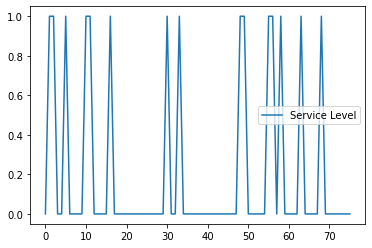

In [12]:
print(c_supply_df)
c_supply_df.plot(y = 'Service Level')

In [153]:
service_level_df

,Time_Period,Service_Current,Service_Future
0,0,20.831277,20.831277


In [156]:
c_supply_df.loc[c_supply_df['Municipality'].isin(study_area)]

,Municipality,Time_Period_1,Demand,Service Level
1,Aguada,18.208246,18.208246,1.0
2,Aguadilla,47.600972,47.600972,1.0
5,Añasco,29.849644,29.849644,1.0
33,Hormigueros,8.513173,8.513173,1.0
35,Isabela,0.000000,21.289861,0.0
48,Mayagüez,76.731217,76.731217,1.0
49,Moca,18.958879,18.958879,1.0
58,Rincón,6.704276,6.704276,1.0


In [23]:
study_area = ['Aguada','Aguadilla','Añasco','Isabela','Hormigueros','Moca','Mayagüez','Rincón']